# Praxisbeispiel Katzen vs. Hunde
In diesem Jupiternotebook wird Schritt für Schritt erläutert, wie man mithilfe von Tensorflow,
Neuronale Netzwerke erstellt, trainiert und bewertet sowie Daten lädt und für das Training vorbereitet.

## I. Import der notwendigen Module


- ``tensorflow`` und ``keras`` für das Neuronale Netzwerk
- ``Matplolib`` für das Anzeigen von Bildern und Grafiken

In [13]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline 
from typing import List
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
import os
import numpy as np

ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator
os.chdir(r'C:\Users\nic-e\Datasets\PetImages')

## II. Laden und Untersuchen des Datensatzes
- Dieser beinhaltet ``Bilder`` von ``Hunden`` und ``Katzen``
- Zu jedem Bild gibt es ein ``Label`` das angibt welches der beiden Tiere auf dem Bild zu sehen ist.
- ``0`` steht dabei für eine Katze
- ``1`` steht für einen Hund

Metadaten:
- Insgesamt 25000
- 12.500 Bilder von Katzen
- 12.500 Bilder von Hunden

- Bilder haben 3 Farbchannels (RGB)

#### Untersuchen der Daten
Virtuelle darstellung der Bilder

<img src="./images/rgb_layers.png" alt="Alt text that describes the graphic" title="Title text" style="width:500px;height:300px" />

In [3]:
images = []
for i in range(10):
  im = img.imread('Cat/{}.jpg'.format(i))
  images.append(im)
  print('image shape', im.shape, 'maximum color level', im.max())

image shape (375, 500, 3) maximum color level 255
image shape (281, 300, 3) maximum color level 239
image shape (397, 312, 3) maximum color level 255
image shape (415, 500, 3) maximum color level 255
image shape (375, 500, 3) maximum color level 255
image shape (144, 176, 3) maximum color level 255
image shape (304, 400, 3) maximum color level 255
image shape (500, 495, 3) maximum color level 255
image shape (346, 461, 3) maximum color level 255
image shape (426, 320, 3) maximum color level 249


#### Data cleaning

Bevor man mit den Daten arbeitet, muss man sicherstellen das die Qualität der Daten auch ensprechend den Anforderungen ist.

Der Datensatz enthält einige Bilder die nichts mit dem Datensatz zutun haben.

In [5]:
bad_dog_ids = [5604, 6413, 8736, 8898, 9188, 9517, 10161, 
               10190, 10237, 10401, 10797, 11186]

bad_cat_ids = [2939, 3216, 4688, 4833, 5418, 6215, 7377, 
               8456, 8470, 11565, 12272]

In [6]:
def load_images(ids, categ):
  '''return the images corresponding to a list of ids'''
  images = []
  dirname = categ+'s' # dog -> dogs
  for theid in ids: 
    fname = '{categ}/{theid}.jpg'.format(
        dirname=dirname,
        categ=categ, 
        theid=theid
    )
    im = img.imread(fname)
    images.append(im)
  return images

bad_dogs = load_images(bad_dog_ids, 'dog')
bad_cats = load_images(bad_cat_ids, 'cat')

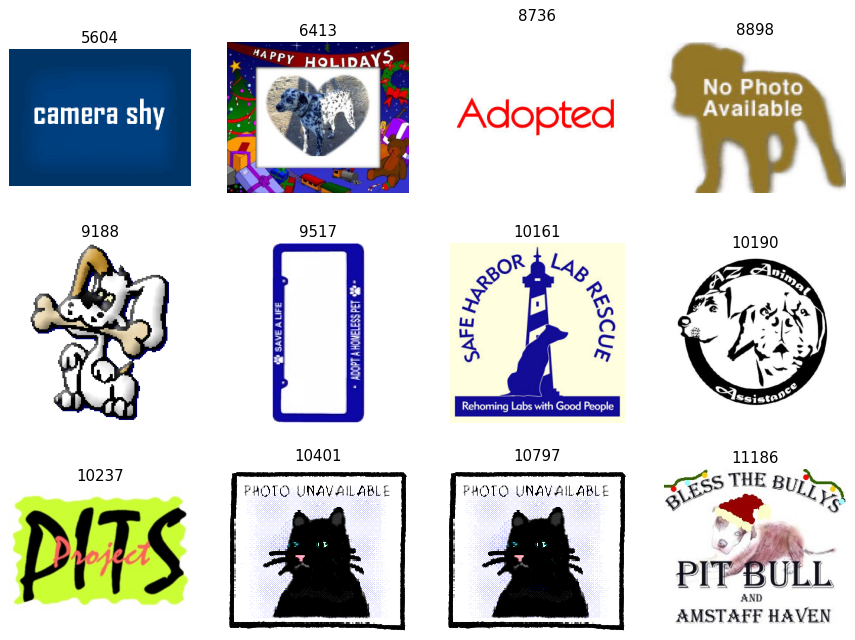

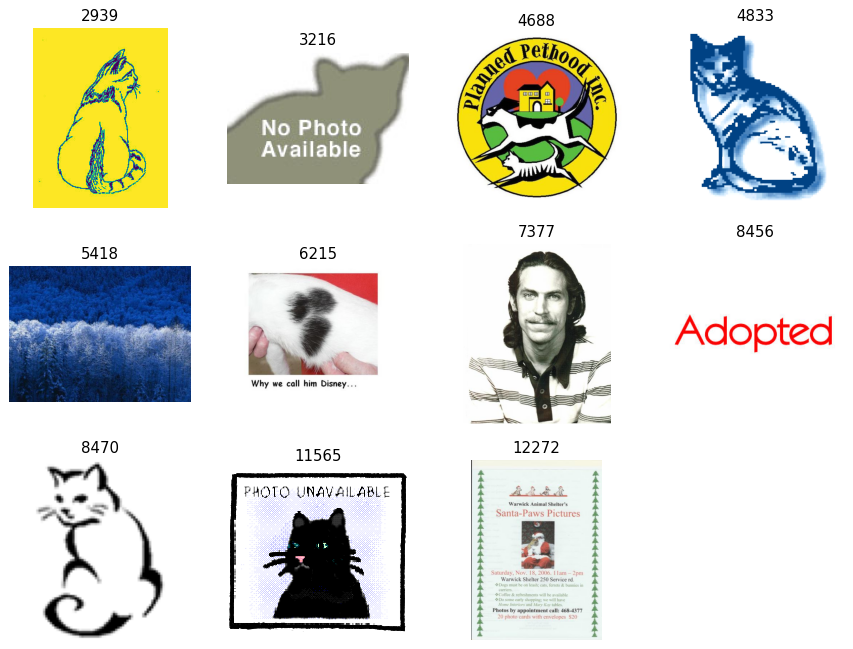

In [7]:
def plot_images(images, ids):
    ncols, nrows = 4, 3
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img, theid) in enumerate(zip(images,ids)):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(img)
      plt.title(str(theid))
      plt.axis('off')

plot_images(bad_dogs, bad_dog_ids)
plot_images(bad_cats, bad_cat_ids)

### Data Preprocessing und Laden
- Die Bilder Brauchen eine einheitliche Größe, damit das Neuronale Netzwerk darauf konfiguriert werden kann.

Hierfür definieren wir ein Funktion die über die Daten iteriert und alle bilder auf die Gleiche `Höhe` und `Breite` skaliert.

Des weiteren werden die Bilder in Gruppen von jeweils 32 Bildern zusammengefasst. Diese Gruppen nennt man einen ``batch``.

<img src="./images/Batch.png" alt="Alt text that describes the graphic" title="Title text" style="width:900px;height:450px" />

Dies ist von Vorteil, da hier nicht nach jedem Bild Backpropagation angewendet wird, sondern erst nach ausrechnen eines gesamten Batches. Dies Beschläuning das Traning um ein vielfaches und kann auch positiv für die Generalisierung des neuronales Netzwerkes sein.

In [9]:
os.chdir(r'C:\Users\nic-e\Datasets\PetImages_cleaned')
BATCH_SIZE = 32
HEIGHT, WIDTH = (256,256)

img_generator = ImageDataGenerator(
    rescale = 1/255., 
    horizontal_flip = True, 
    zoom_range = 0.3, 
    rotation_range = 15.,
    validation_split = 0.2,
)

train_dataset = img_generator.flow_from_directory(
    os.getcwd(),
    target_size = (HEIGHT, WIDTH), 
    classes = ('Dog','Cat'),
    batch_size = BATCH_SIZE,
    subset = 'training'
)

val_dataset = img_generator.flow_from_directory(
    os.getcwd(),
    target_size = (HEIGHT, WIDTH), 
    classes = ('Dog','Cat'),
    batch_size = BATCH_SIZE,
    subset = 'validation'
)

Found 19980 images belonging to 2 classes.
Found 4994 images belonging to 2 classes.


Der Batch hat 2 Elemente
Die Daten haben folgende Dimensionen: (32, 256, 256, 3)
Die Daten haben folgenden Datentyp: float32
Die Labels haben folgende Dimensionen: (32, 2)
Die labels haben den folgenden Datentyp: float32


array([1., 0.], dtype=float32)

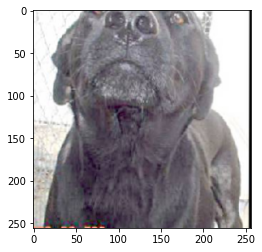

In [17]:
batch = train_dataset.next()
print(f'Der Batch hat {len(batch)} Elemente') # how many elements does the batch have
print(f'Die Daten haben folgende Dimensionen: {batch[0].shape}')
print(f'Die Daten haben folgenden Datentyp: {batch[0].dtype}')
print(f'Die Labels haben folgende Dimensionen: {batch[1].shape}')
print(f'Die labels haben den folgenden Datentyp: {batch[1].dtype}')


plt.imshow(batch[0][0])
batch[1][0]

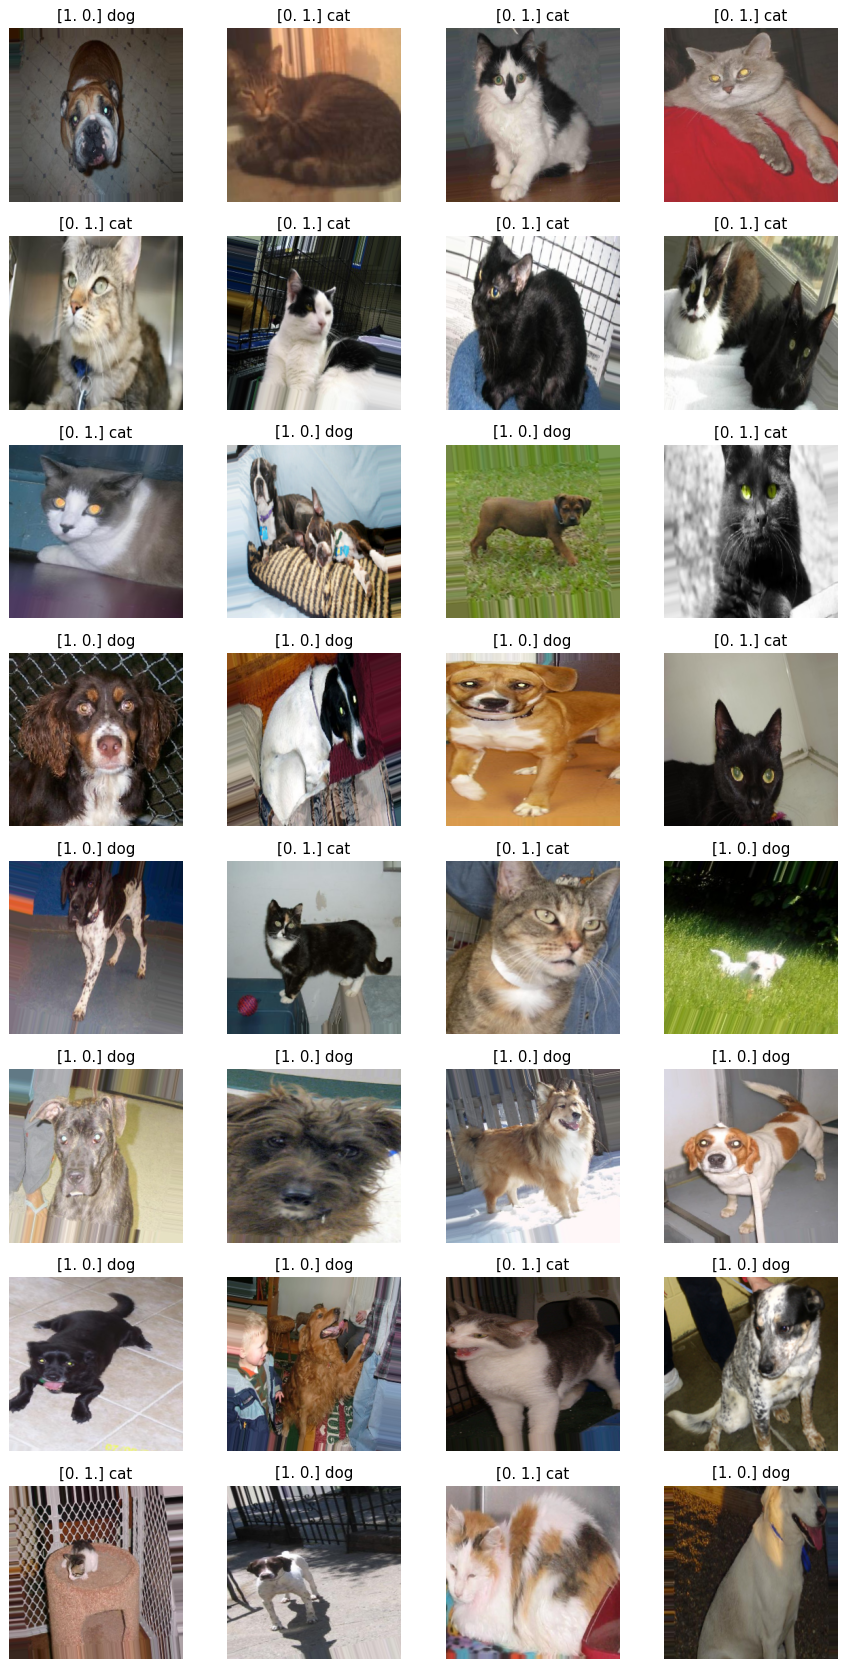

In [18]:
def plot_images(batch):
    imgs = batch[0]
    labels = batch[1]
    ncols, nrows = 4,8
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img,label) in enumerate(zip(imgs,labels)):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(img)
      assert(label[0]+label[1]==1.)
      categ = 'dog' if label[0]>0.5 else 'cat'
      plt.title( '{} {}'.format(str(label), categ))
      plt.axis('off')

plot_images(train_dataset.next())

## Erstellen des Neuronalen Netzwerks

#### Dense Layer
<img src="./images/Dense_Layer.png" alt="Alt text that describes the graphic" title="Title text" style="width:600px;height:300px" />

#### Convolutional Layer
<img src="./images/Convolutional_Layer.png" alt="Alt text that describes the graphic" title="Title text" style="width:900px;height:450px" />

#### Kernel
<img src="./images/ConvolutionII.png" alt="Alt text that describes the graphic" title="Title text" />

#### Max Pooling Layer
<img src="./images/MaxPoolingLayer.png" alt="Alt text that describes the graphic" title="Title text" />



In [28]:
def get_model():
    model = keras.models.Sequential()

    model.add( 
        keras.layers.Conv2D(
            24, 5, input_shape=(256,256,3), 
            activation='relu', 
        )
    )
    model.add(MaxPooling2D(2))
    model.add(Conv2D(48, 5, activation='relu',))
    model.add(MaxPooling2D(2) )
    model.add(Conv2D(96, 5, activation='relu',))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.9))
    model.add(keras.layers.Dense(2, activation='softmax',))

    # Print a summary of the model and compile it
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adamax(lr=0.001), metrics=['acc'])    
    return model

# Trainieren des Models

- das Modell wird trainiert und die Trainingshistorie wird gespeichert

In [29]:
model = get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 252, 252, 24)      1824      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 126, 126, 24)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 122, 122, 48)      28848     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 61, 61, 48)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 57, 57, 96)        115296    
                                                                 
 flatten_1 (Flatten)         (None, 311904)           

In [51]:
history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=24,
    epochs=20,
)

C:\Users\nic-e\AppData\Local\Temp/ipykernel_27316/2405436493.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
667/667 [==============================] - 39s 57ms/step - loss: 0.6451 - acc: 0.6237 - val_loss: 0.5604 - val_acc: 0.7179
Epoch 2/20
667/667 [==============================] - 39s 58ms/step - loss: 0.5697 - acc: 0.7025 - val_loss: 0.5389 - val_acc: 0.7211
Epoch 3/20
667/667 [==============================] - 38s 57ms/step - loss: 0.5406 - acc: 0.7340 - val_loss: 0.5084 - val_acc: 0.7483
Epoch 4/20
667/667 [==============================] - 38s 56ms/step - loss: 0.5051 - acc: 0.7549 - val_loss: 0.4770 - val_acc: 0.7733
Epoch 5/20
667/667 [==============================] - 37s 55ms/step - loss: 0.4835 - acc: 0.7699 - val_loss: 0.4397 - val_acc: 0.7961
Epoch 6/20
667/667 [==============================] - 38s 56ms/step - loss: 0.4535 - acc: 0.7875 - val_loss: 0.4727 - val_acc: 0.7795
Epoch 7/20
667/667 [==============================] - 37s 55ms/step - loss: 0.4438 - acc: 0.7966 - val_loss: 0.4252 - val_acc: 0.8141
Epoch 8/20
667/667 [==============================] - 37s 55ms

# Trainigshistorie

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


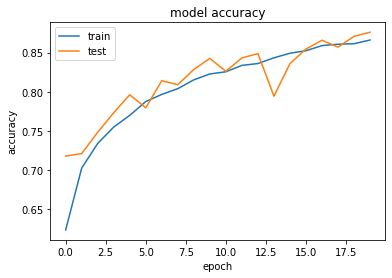

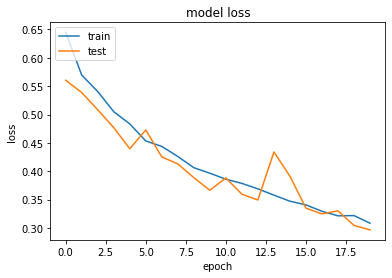

In [52]:

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:

from PIL import Image
dir = os.listdir('./Cat')
for i in dir:
  m = Image.open(f'Cat/{i}')
  m.load()
  print(i)

0.jpg
1.jpg
10.jpg
100.jpg
1000.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg
10009.jpg
1001.jpg
10010.jpg
10011.jpg
10012.jpg
10013.jpg
10014.jpg
10015.jpg
10016.jpg
10017.jpg
10018.jpg
10019.jpg
1002.jpg
10020.jpg
10021.jpg
10022.jpg
10023.jpg
10024.jpg
10025.jpg
10026.jpg
10027.jpg
10028.jpg
10029.jpg
1003.jpg
10030.jpg
10031.jpg
10032.jpg
10033.jpg
10034.jpg
10035.jpg
10036.jpg
10037.jpg
10038.jpg
10039.jpg
1004.jpg
10040.jpg
10041.jpg
10042.jpg
10043.jpg
10044.jpg
10045.jpg
10046.jpg
10047.jpg
10048.jpg
10049.jpg
1005.jpg
10050.jpg
10051.jpg
10052.jpg
10053.jpg
10054.jpg
10055.jpg
10056.jpg
10057.jpg
10058.jpg
10059.jpg
1006.jpg
10060.jpg
10061.jpg
10062.jpg
10063.jpg
10064.jpg
10065.jpg
10066.jpg
10067.jpg
10068.jpg
10069.jpg
1007.jpg
10070.jpg
10071.jpg
10072.jpg
10073.jpg
10074.jpg
10075.jpg
10076.jpg
10077.jpg
10078.jpg
10079.jpg
1008.jpg
10080.jpg
10081.jpg
10082.jpg
10083.jpg
10084.jpg
10085.jpg
10086.jpg
10087.jpg
10088.jpg
10